In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier,Perceptron
from sklearn import tree
#from sklearn.linear_model import Perceptron
#from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [180]:

#Original
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#print(train.shape)
#train.head(10)

#Update
#I had to split the training file because the test file doesn't have any ground-truth labels so we can't find testing accuracy from it
#from sklearn.model_selection import train_test_split
#file = pd.read_csv('train.csv')
#train, test = train_test_split(file, test_size=0.2)


In [181]:
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [182]:
test.insert(1,'Survived',0)
print(test.shape)
test.head()

(418, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,0,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,0,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [183]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [184]:
test.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [185]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

<AxesSubplot:>

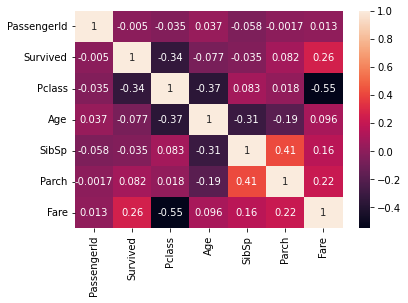

In [186]:
sns.heatmap(train.corr(),annot=True)

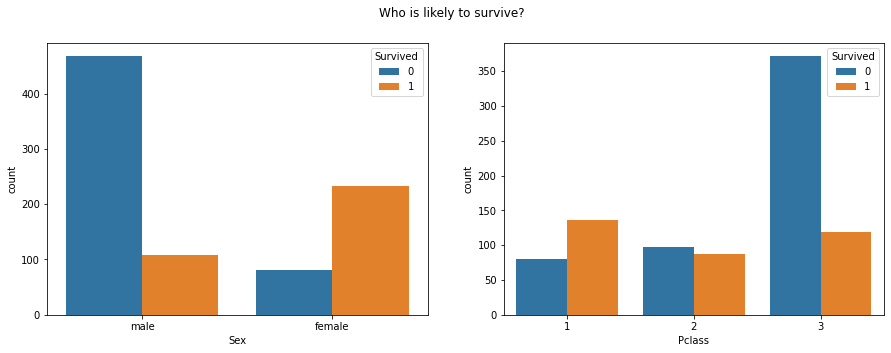

In [187]:
f,ax = plt.subplots(1,2,figsize=(15,5))
f.suptitle('Who is likely to survive?')
sns.countplot(x='Sex',hue='Survived',data=train,ax=ax[0])
sns.countplot(x='Pclass',hue='Survived',data=train,ax=ax[1])
plt.show()

- The first plot shows that the female is more likely to survive than male.
- The second plot shows that individuals in the first class are more likely to survive than other classes.

## Filling in missing values

### Cabin

The deck was determined by the letter in the cabin. We will group the cabins based on the deck they are on. For all the missing values, we will fill in U for unknown.

In [188]:
print('number of unique cabins: '+str(train['Cabin'].nunique())+ ' and number of missing cabins: '+ str(train['Cabin'].isnull().sum()))

number of unique cabins: 147 and number of missing cabins: 687


In [189]:
train['deck'] = train['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'U')
# we want to get this for the test set for later too
test['deck'] = test['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'U')


Text(0.5, 1.0, 'Survival rates by deck')

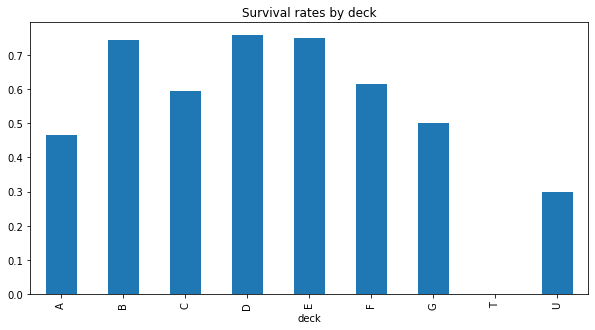

In [190]:
# then let's check our assumptions about the survival by deck
train[['deck', 'Survived']].groupby('deck')['Survived'].mean().plot(kind='bar',figsize=(10,5))
plt.title('Survival rates by deck')


In [191]:
train['deck'].value_counts()

U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: deck, dtype: int64

We will add deck T to deck U as there is only 1 value in deck T.

In [192]:
train.loc[train['deck'] == 'T', 'deck'] = 'U'

In [193]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,U
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,U
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C


### Age

- We are to check how age affects the survival rate.
- Based on the heatmap, there is a correlation between age and Pclass.
- We can also check if age makes a difference based on gender. 


<AxesSubplot:xlabel='Age', ylabel='Density'>

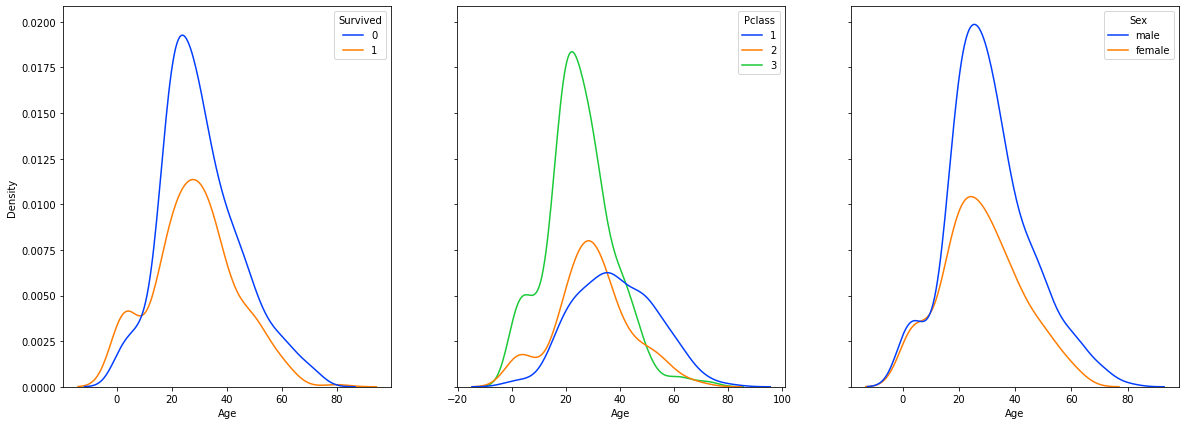

In [194]:
f,ax= plt.subplots(1,3,figsize=(20,7),sharey=True)
sns.kdeplot(x='Age',data=train,hue='Survived',palette='bright',ax=ax[0])
sns.kdeplot(x='Age',data=train,hue='Pclass',palette='bright',ax=ax[1])
sns.kdeplot(x='Age',data=train,hue='Sex',palette='bright' ,ax=ax[2])



- The first plot shows that people between the ages 20 and 40 survived more than the rest.
- The second plot shows that people in the first class are slightly older than the other classes.
- The third plot shows that there are differences in age based on sex. We can say age is correlated to sex.

With this said, we cannot use the overall mean/median to fill in all the missing values. We will take into account the sex and class of each individual, so using the mean/median per category might be better approach.

In [195]:
print('number of missing ages: '+str(train['Age'].isnull().sum()))

number of missing ages: 177


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

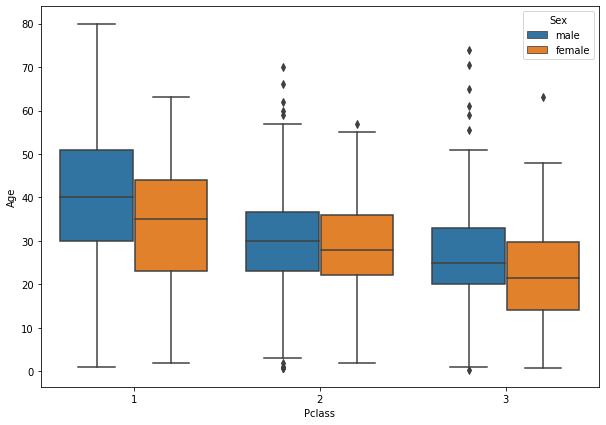

In [196]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass',y='Age',hue='Sex',data=train)

In [197]:
#There is an age difference between the ages of difreent classes and sex within the dataset
train['Age'] = train.groupby(['Sex','Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

#get this for the test data too
test['Age'] = test.groupby(['Sex','Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))



### Embarked

<AxesSubplot:xlabel='Embarked', ylabel='count'>

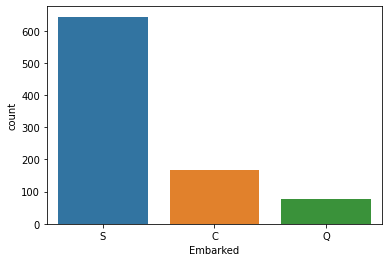

In [198]:
sns.countplot(x='Embarked',data=train)

In [199]:
print('The number of missing values for Embarked port: '+str(train['Embarked'].isnull().sum()))
train[train['Embarked'].isnull()]



The number of missing values for Embarked port: 2


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,deck
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B


The most common port is S (SouthHamptons). So we will use this port to fill in the missing ports.

In [200]:
train['Embarked']=train['Embarked'].fillna(value='S')



### Fare

We will fill in the missing fare value based on the class and port embarked.

In [201]:
test[test['Fare'].isnull()]



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,deck
152,1044,0,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,U


In [202]:
x = test[(test['Pclass']=='3')& (test['Embarked']=='S')]['Fare'].median()
test['Fare']= test['Fare'].fillna(x)



## Feature Engineering

### Name

We can extract the title from the name feature and form categories based on the titles.

In [203]:
train['Title'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# do the same for test
test['Title'] = test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())



<AxesSubplot:xlabel='Title', ylabel='count'>

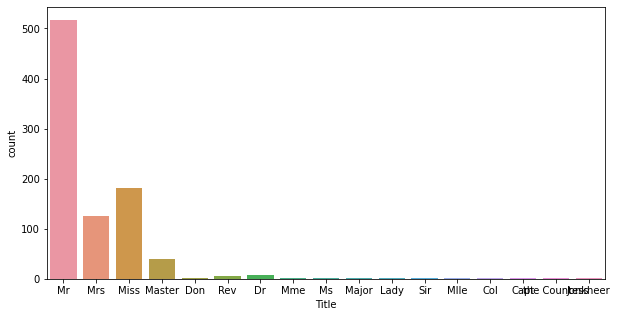

In [204]:
plt.figure(figsize=(10,5))
sns.countplot(x='Title',data=train)



In [205]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,deck,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,U,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,U,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,U,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,U,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.5,1,2,W./C. 6607,23.4500,NaN,S,U,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C,Mr


Some titles have few values, so we have grouped them as Other.

In [206]:
train['Title'] = np.where(train['Title'].isin(['Mr', 'Mrs', 'Master', 'Miss']), train['Title'], 'Other')

#do the same for test
test['Title'] = np.where(test['Title'].isin(['Mr', 'Mrs', 'Master', 'Miss']), test['Title'], 'Other')



In [207]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,deck,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,U,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,U,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,U,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,U,Other
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.5,1,2,W./C. 6607,23.4500,NaN,S,U,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C,Mr


<AxesSubplot:xlabel='Title', ylabel='count'>

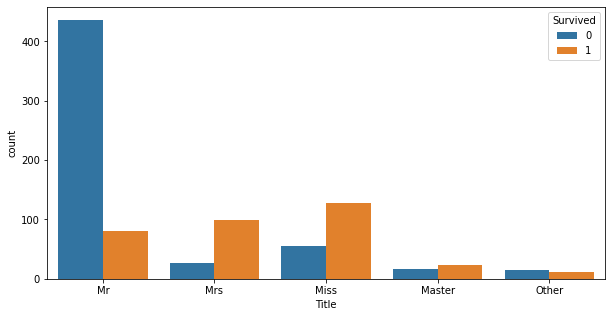

In [208]:
plt.figure(figsize=(10,5))
sns.countplot(x='Title',data=train,hue='Survived')



### Ticket

Some tickects contain letters and numerical values.The plan is to remove all the letters form the string, then group the tickets based on the first leading digit.


In [209]:
#check if there a letters or not
def prefix(ticket):
    
    check = ticket.split(' ')[0][0]
    if check.isalpha():
        return ticket.split(' ')[0]
    else:
        return 'No prefix'

def ticket_features(df):
    
    df['Ticket'] = df['Ticket'].replace('LINE','LINE 0')
    df['Ticket'] = df['Ticket'].apply(lambda x: x.replace('.','').replace('/','').lower())
    df['Prefix'] = df['Ticket'].apply(lambda x: prefix(x))
    df['TNumeric'] = df['Ticket'].apply(lambda x: int(x.split(' ')[-1]))
    df['TNlen'] = df['TNumeric'].apply(lambda x : len(str(x)))
    df['Ticket_LeadingDigit'] = df['TNumeric'].apply(lambda x : int(str(x)[0]))
    df['TGroup'] = df['TNumeric'].apply(lambda x: str(x//10))

    df = df.drop(columns=['Ticket','TNumeric','Prefix','TNlen','TGroup'])

    return df

train = ticket_features(train)
test = ticket_features(test)
train.head(1)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,deck,Title,Ticket_LeadingDigit
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.25,NaN,S,U,Mr,2


In [210]:
train['deck'].unique()



array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F'], dtype=object)

### Encoding Categorical features

In [211]:
# encoding sex column
train.replace({'Sex':{'male':0,'female':1}}, inplace=True)
test.replace({'Sex':{'male':0,'female':1}}, inplace=True)

 # encoding 'embarked' column
train.replace({'Embarked':{'C':0,'S':1, 'Q':2}}, inplace=True)
test.replace({'Embarked':{'C':0,'S':1, 'Q':2}}, inplace=True)

#encoding title column
train.replace({'Title':{'Mr':0,'Mrs':1, 'Master':2, 'Miss':3, 'Other':4}}, inplace=True)
test.replace({'Title':{'Mr':0,'Mrs':1, 'Master':2, 'Miss':3, 'Other':4}}, inplace=True)

deck = pd.get_dummies(train['deck'],prefix='Cabin')
train = train.drop(columns= ['Cabin', 'Name', 'deck'], axis=1)
train= pd.concat([train,deck],axis=1)

deck1 = pd.get_dummies(test['deck'],prefix='Cabin')
test = test.drop(columns= ['Cabin', 'Name' , 'deck'], axis=1)
test= pd.concat([test,deck1],axis=1)


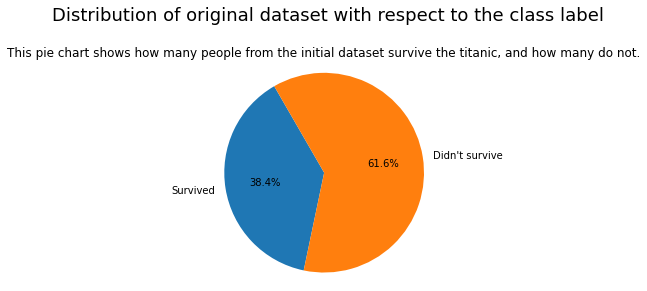

In [212]:
num_survived = sum(train['Survived'] == 1)
num_not_survived = sum(train['Survived'] == 0)

labels = ["Survived", "Didn't survive"]
sizes = [num_survived, num_not_survived]

# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%',  startangle=120)
plt.axis('equal')
plt.suptitle("Distribution of original dataset with respect to the class label", y=1, fontsize=18)
plt.title("This pie chart shows how many people from the initial dataset survive the titanic, and how many do not.")
plt.tight_layout()
plt.show()

In [213]:
y = train['Survived']
x = train.drop(['Survived', 'PassengerId'], axis=1)

In [214]:
std_scaler = StandardScaler()
x = std_scaler.fit_transform(x)
test = std_scaler.fit_transform(test)
test.shape


(418, 19)

In [215]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y, test_size=0.2,random_state=0)

In [216]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((712, 17), (179, 17), (712,), (179,))

In [220]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix,ConfusionMatrixDisplay

logreg = LogisticRegression(tol=0.005, C=1, max_iter= 1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
#print(getAccuracy(y_test, y_pred))

print("Logistic Regression Metrics:\n")
print(f"Training Accuracy: {logreg.score(X_train,y_train)}")
print(f"Testing Accuracy: {logreg.score(X_test,y_test)}")
print(f"Precision: {precision_score(y_test, logreg.predict(X_test),average='binary')}")
print(f"Recall: {recall_score(y_test, logreg.predict(X_test),average='binary')}")
print(f"F1 Score: {f1_score(y_test, logreg.predict(X_test),average='binary')}")
print(f"Matthew's Correlation Coefficient: {matthews_corrcoef(y_test, logreg.predict(X_test))}")

Logistic Regression Metrics:

Training Accuracy: 0.8216292134831461
Testing Accuracy: 0.7932960893854749
Precision: 0.7352941176470589
Recall: 0.7246376811594203
F1 Score: 0.7299270072992701
Matthew's Correlation Coefficient: 0.5625599667750646


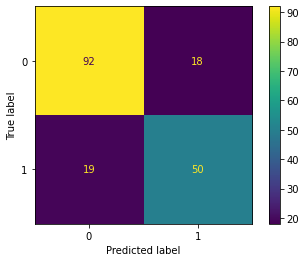

In [222]:
c_matrix = confusion_matrix(y_test, logreg.predict(X_test))
d=ConfusionMatrixDisplay(c_matrix)
d.plot()

In [264]:
#optimization of Logistic Regression hyperparameters
lr = LogisticRegression()
param_grid = {'max_iter' : [100,200,2000,5000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 8, 15),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 4, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train,y_train)
print('Best Accuracy: ' + str(np.round(best_clf_lr.best_score_*100,2))+'%')
print('Best Parameters: ' + str(best_clf_lr.best_params_))
print('Accuracy of Logistic Regression In Test-set :'+str(np.round(best_clf_lr.score(X_test,y_test)*100,2))+'%')

Fitting 4 folds for each of 120 candidates, totalling 480 fits
Best Accuracy: 80.9%
Best Parameters: {'C': 0.2682695795279725, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy of Logistic Regression In Test-set :79.89%


## Stochastic Gradient Descent (Logistic Regression with Gradient Descent)

In [246]:
stochGD = SGDClassifier(max_iter=1000, tol=1e-3)
second = stochGD.fit(X_train, y_train) #coef_init not working
print("Stochastic Gradient Descent Metrics:\n")
print(f"Training Accuracy: {stochGD.score(X_train,y_train)}")
print(f"Testing Accuracy: {stochGD.score(X_test,y_test)}")
print(f"Precision: {precision_score(y_test, stochGD.predict(X_test),average='binary')}")
print(f"Recall: {recall_score(y_test, stochGD.predict(X_test),average='binary')}")
print(f"F1 Score: {f1_score(y_test, stochGD.predict(X_test),average='binary')}")
print(f"Matthew's Correlation Coefficient: {matthews_corrcoef(y_test, stochGD.predict(X_test))}")


Stochastic Gradient Descent Metrics:

Training Accuracy: 0.7851123595505618
Testing Accuracy: 0.7988826815642458
Precision: 0.6987951807228916
Recall: 0.8405797101449275
F1 Score: 0.763157894736842
Matthew's Correlation Coefficient: 0.5985826638658058


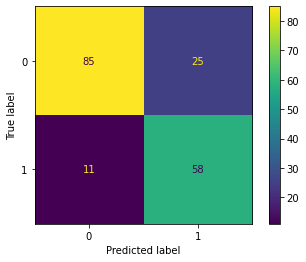

In [247]:
c_matrix = confusion_matrix(y_test, stochGD.predict(X_test))
d=ConfusionMatrixDisplay(c_matrix)
d.plot()

In [257]:
#hyper parameter optimisation
sgd=SGDClassifier()
param_grid = {
    "loss" : ["hinge", "log_loss", "modified_huber", "perceptron", "squared_hinge"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    'eta0': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
    'max_iter': []

}
              
    

clf_sgd = GridSearchCV(sgd, param_grid = param_grid, cv = 4, verbose = True, n_jobs = -1)
best_clf_sgd = clf_sgd.fit(X_train,y_train)
print('Best Score: ' + str(np.round(best_clf_sgd.best_score_*100,2))+'%')
print('Best Parameters: ' + str(best_clf_sgd.best_params_))
print('Accuracy of Stochastic Gradient Descent Classifier In Test-set :'+str(np.round(best_clf_sgd.score(X_test,y_test)*100,2))+'%')

Fitting 4 folds for each of 480 candidates, totalling 1920 fits


/home/kgethi/.pyenv/versions/3.10.4/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kgethi/.pyenv/versions/3.10.4/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kgethi/.pyenv/versions/3.10.4/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kgethi/.pyenv/versions/3.10.4/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before con

/home/kgethi/.pyenv/versions/3.10.4/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kgethi/.pyenv/versions/3.10.4/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kgethi/.pyenv/versions/3.10.4/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kgethi/.pyenv/versions/3.10.4/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before con

Best Score: 81.46%
Best Parameters: {'alpha': 0.1, 'eta0': 1e-05, 'loss': 'log_loss', 'penalty': 'none'}
Accuracy of Stochastic Gradient Descent Classifier In Test-set :77.65%


/home/kgethi/.pyenv/versions/3.10.4/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kgethi/.pyenv/versions/3.10.4/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


## Decision Tree

In [261]:
dec_tree = tree.DecisionTreeClassifier()
dec_tree = dec_tree.fit(X_train, y_train)
#tree.plot_tree(dec_tree)
print("Decision Trees Metrics:\n")
print(f"Training Accuracy: {dec_tree.score(X_train,y_train)}")
print(f"Testing Accuracy: {dec_tree.score(X_test,y_test)}")
print(f"Precision: {precision_score(y_test, dec_tree.predict(X_test),average='binary')}")
print(f"Recall: {recall_score(y_test, dec_tree.predict(X_test),average='binary')}")
print(f"F1 Score: {f1_score(y_test, dec_tree.predict(X_test),average='binary')}")
print(f"Matthew's Correlation Coefficient: {matthews_corrcoef(y_test, dec_tree.predict(X_test))}")

Decision Trees Metrics:

Training Accuracy: 0.9901685393258427
Testing Accuracy: 0.7653631284916201
Precision: 0.7142857142857143
Recall: 0.6521739130434783
F1 Score: 0.6818181818181819
Matthew's Correlation Coefficient: 0.49787413878766656


In [144]:
model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = SGDClassifier()
model4 = Perceptron(tol=1e-3, random_state=0)

models = [model1, model2, model3, model4]
i = 0
for model in models:
    i +=1
    cv= cross_val_score(model,X_train,y_train,cv=5)
    cv1= cross_val_score(model,X_test,y_test,cv=5)
    print("Model", i,":", model)
    print("Training accuracy: "+str(np.round(cv.mean()*100,2))+'%')
    #print("Testing accuracy: "+str(np.round(cv1.mean()*100,2))+'%')

Model 1 : LogisticRegression()
Training accuracy: 79.36%
Model 2 : RandomForestClassifier()
Training accuracy: 80.76%
Model 3 : SGDClassifier()
Training accuracy: 75.7%
Model 4 : Perceptron()
Training accuracy: 64.47%


In [145]:
#Linear regression
lr=LogisticRegression()
lr.fit(X_train,y_train)
cv = cross_val_score(lr,X_test,y_test,cv=5)
print("Testing accuracy: "+str(np.round(cv.mean()*100,2))+'%')
print(classification_report(y_test,lr.predict(X_test)))

Testing accuracy: 81.59%
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       110
           1       0.74      0.72      0.73        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [177]:
lr = LogisticRegression()
param_grid = {'max_iter' : [100,200,2000,5000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train,y_train)
print('Best Score: ' + str(best_clf_lr.best_score_))
print('Best Parameters: ' + str(best_clf_lr.best_params_))
predictions = best_clf_lr.predict(X_test)
accuracy = accuracy_score(y_test , predictions)
print('Accuracy of Logistic Regression In Test-set :'+str(np.round(accuracy*100,2))+'%')

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best Score: 0.7977642076233625
Best Parameters: {'C': 0.03359818286283781, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy of Logistic Regression In Test-set :77.65%


In [147]:
#Rand Forest
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
cv = cv= cross_val_score(rf,X_test,y_test,cv=5)
print("Testing accuracy: "+str(np.round(cv.mean()*100,2))+'%')
print(classification_report(y_test,rf.predict(X_test)))

Testing accuracy: 84.37%
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       110
           1       0.82      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



In [178]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train,y_train)
print('Best Score: ' + str(best_clf_rf.best_score_))
print('Best Parameters: ' + str(best_clf_rf.best_params_))
predictions = best_clf_rf.predict(X_test)
accuracy = accuracy_score(y_test , predictions)
print('Accuracy of Random Forest Classifier In Test-set :'+str(np.round(accuracy*100,2))+'%')

Fitting 5 folds for each of 192 candidates, totalling 960 fits


KeyboardInterrupt: 

In [151]:
#SGD classifier
sgd=SGDClassifier()
sgd.fit(X_train,y_train)
cv = cv= cross_val_score(lr,X_test,y_test,cv=5)
print("Testing accuracy: "+str(np.round(cv.mean()*100,2))+'%')
print(classification_report(y_test,sgd.predict(X_test)))

Testing accuracy: 81.59%
              precision    recall  f1-score   support

           0       0.84      0.77      0.81       110
           1       0.68      0.77      0.72        69

    accuracy                           0.77       179
   macro avg       0.76      0.77      0.76       179
weighted avg       0.78      0.77      0.77       179



In [171]:
#hyper parameter optimisation
sgd=SGDClassifier()
param_grid = {
    "loss" : ["hinge", "log_loss", "modified_huber", "perceptron", "squared_hinge"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
    "max_iter" : [5000000]

}
              
    

clf_sgd = GridSearchCV(sgd, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_sgd = clf_sgd.fit(X_train,y_train)
print('Best Score: ' + str(best_clf_sgd.best_score_))
print('Best Parameters: ' + str(best_clf_sgd.best_params_))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


KeyboardInterrupt: 

In [ ]:
#Linear regression
precep=Perceptron()
precep.fit(X_train,y_train)
cv = cv= cross_val_score(lr,X_test,y_test,cv=5)
print("Testing accuracy: "+str(np.round(cv.mean()*100,2))+'%')
print(classification_report(y_test,precep.predict(X_test)))

In [ ]:
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test , dpredictions)

Convert Dataframe to Matrix

In [237]:
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

x_train = np.insert(x_train, 0, 1, axis=1) #insert a first column of 1's as x0 
print(x_train)

[[1. 3. 0. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 3. 1. ... 0. 0. 1.]
 ...
 [1. 3. 1. ... 0. 0. 1.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 3. 0. ... 0. 0. 1.]]


Initialise B: set of training parameters

In [238]:
B = np.random.normal(size = x_train.shape[1]) #x_train.shape[1] = number of features including x0
print(B)

[ 0.41104331 -0.57114616  1.31036214 -0.98092781  0.65443605  0.30465095
 -0.71840546 -0.26774778 -1.85898789 -1.50163389 -0.13732422 -0.67690997
 -0.39419961 -1.23267024  0.26282889  0.77477468  0.81960321  1.90575686]


Sigmoid function

In [239]:
def sigmoid(x):
    if x > 700:      #avoid math overflow error
        sig = 1.0

    elif x <= -700: #avoid math overflow error
        sig = 0

    else:
        sig = 1 / (1 + math.exp(-x))
        
    return sig

get H_x from function below

In [240]:
def g_z(X, B):
    Y = []
    for i in range(X.shape[0]):
        z = np.dot(X[i], B) #multiply B times X
        Y.append(sigmoid(z))
    
    return np.asarray(Y) #convert list to array

Error Function

In [241]:
def J_B(true_y, pred_y, B, regPara):
    epsilon = 1e-5 # to prevent 0 values in log

    a  = (true_y * np.log(pred_y + epsilon)) + ((1-true_y) * np.log((1 - pred_y) +epsilon))
    b = regPara * (np.sum(np.square(B[1:]))) 
    return (-1 * np.sum(a)) + b

Get Prediction Function

In [242]:
def getPredictions(H_x):
    Y = []
    for i in range(H_x.size):
        if(H_x[i] >= 0.5):
            Y.append(1)
        else:
            Y.append(0)
    return np.asarray(Y)

Get Accuracy function

In [243]:
def getAccuracy(y_true, y_pred):
    sum = 0
    for i in range(y_true.size):
        if y_true[i] == y_pred[i]:
            sum = sum + 1
            
    return np.round(sum/y_true.size,4)

Gradient Descent with regularization Function

In [244]:
 #Y(actual values),X(features), B(training parameters), reg_para(regularisation parameter), l_rate(learning rate), epsilon(stop GD when norm < epsilon)
def Grad_Desc(Y, X, B, reg_para, l_rate, epsilon):
    norm = epsilon + 1
    H_x = g_z(X, B)
    B_old = B.copy()
    while norm > epsilon:
        for i in range(B.size):
            if i == 0: # no regularization
                B[i] = B[i] - (l_rate * np.sum(H_x - Y))
            else:
                B[i] = B[i] - (l_rate * (np.sum((H_x - Y) * X[:,i]) - (reg_para * B[i] / X.shape[0])))
        norm = np.linalg.norm(np.subtract(B,B_old), 2)
        H_x = g_z(X, B)
        B_old = B.copy()
        
    return B

In [245]:
print("Original Parameters")
print(B)

h_x = g_z(x_train, B)
print("Original Error: " + str(J_B(y_train, h_x, B, regPara=0.5)) )

print("Accuracy: " + str(getAccuracy(y_train, getPredictions(h_x)) * 100) + "%")

Original Parameters
[ 0.41104331 -0.57114616  1.31036214 -0.98092781  0.65443605  0.30465095
 -0.71840546 -0.26774778 -1.85898789 -1.50163389 -0.13732422 -0.67690997
 -0.39419961 -1.23267024  0.26282889  0.77477468  0.81960321  1.90575686]
Original Error: 3945.505558131784
Accuracy: 61.62%


Perform Gradient Descent

In [246]:
#Testing Data
y_test = test['Survived']
x_test = test.drop(['Survived', 'PassengerId'], axis=1)

y_test = y_test.to_numpy()
x_test = x_test.to_numpy()


x_test = np.insert(x_test, 0, 1, axis=1) #insert a first column of 1's as x0 
print(x_test)

[[1. 3. 0. ... 0. 0. 1.]
 [1. 3. 1. ... 0. 0. 1.]
 [1. 2. 0. ... 0. 0. 1.]
 ...
 [1. 3. 0. ... 0. 0. 1.]
 [1. 3. 0. ... 0. 0. 1.]
 [1. 3. 0. ... 0. 0. 1.]]


In [247]:
print(np.shape(x_test))
print(np.shape(x_train))
print(x_train[0])
print(x_test[0])

(418, 18)
(891, 18)
[ 1.    3.    0.   22.    1.    0.    7.25  1.    0.    2.    0.    0.
  0.    0.    0.    0.    0.    1.  ]
[ 1.      3.      0.     34.5     0.      0.      7.8292  2.      0.
  3.      0.      0.      0.      0.      0.      0.      0.      1.    ]


In [248]:
import time

def Logistic_Regression(new_reg_para,new_l_rate,new_epsilon):
    start_time = time.time()
    B_new = Grad_Desc(y_train, x_train, B.copy(), reg_para=new_reg_para, l_rate=new_l_rate, epsilon=new_epsilon)
    #print("New Parameters")
    #print(B_new)

    h_x_new = g_z(x_train, B_new)
    print("Error after Gradient Descent: " + str(J_B(y_train, h_x_new, B_new, regPara=new_reg_para)) )
    end_time = time.time()
    
    y_pred = getPredictions(h_x_new)
    training_accuracy = getAccuracy(y_train, y_pred)
    #print(f"Learning Rate: {new_l_rate}")
    print(f"Time taken to train model: {end_time-start_time}s")
    print("Training Accuracy: " + str(training_accuracy*100) + " %")
    
    #Testing Data shape not the same as Training Data
    #Testing Accuracy
    h_x_testing = g_z(x_test,B_new)
    y_pred_test = getPredictions(h_x_testing)
    testing_accuracy = getAccuracy(y_test, y_pred_test)
    print("Testing Accuracy: " + str(testing_accuracy*100) + " %\n\n")
    #testing_accuracy = training_accuracy # Delete this when testing data is fixed
    
    return training_accuracy, testing_accuracy

In [249]:
#Logistic Regression with Regression
training_accuracy, testing_accuracy = Logistic_Regression(0.5,0.000005,0.00005)

Error after Gradient Descent: 392.80087191679877
Time taken to train model: 111.740882396698s
Training Accuracy: 81.58999999999999 %
Testing Accuracy: 63.63999999999999 %




In [250]:
#Investigate Effect of Different Learning Rates

#Pick 10 learning rates
learning_rates = [0.0000005 * i for i in range(10)]

#Lists to store training and testing accuracies for each learning rate
training_accuracy_list = []
testing_accuracy_list = [] 

#For each learning rate
for i in range(0,len(learning_rates)):
    print(f"Learning Rate: {learning_rates[i]}")
    training_accuracy, testing_accuracy = Logistic_Regression(0.5, learning_rates[i],0.00005)
    training_accuracy_list.append(training_accuracy)
    testing_accuracy_list.append(testing_accuracy)


Learning Rate: 0.0
Error after Gradient Descent: 3945.505558131784
Time taken to train model: 0.04672360420227051s
Training Accuracy: 61.62 %
Testing Accuracy: 100.0 %


Learning Rate: 5e-07
Error after Gradient Descent: 474.2579083162884
Time taken to train model: 87.37949228286743s
Training Accuracy: 76.09 %
Testing Accuracy: 60.050000000000004 %


Learning Rate: 1e-06
Error after Gradient Descent: 436.62653393295636
Time taken to train model: 80.66643524169922s
Training Accuracy: 77.55 %
Testing Accuracy: 60.77 %


Learning Rate: 1.5e-06
Error after Gradient Descent: 421.92014788691455
Time taken to train model: 85.09532046318054s
Training Accuracy: 78.56 %
Testing Accuracy: 61.72 %


Learning Rate: 2e-06
Error after Gradient Descent: 413.4978307982893
Time taken to train model: 91.65195035934448s
Training Accuracy: 79.24 %
Testing Accuracy: 63.160000000000004 %


Learning Rate: 2.4999999999999998e-06
Error after Gradient Descent: 406.84141853038716
Time taken to train model: 109.55

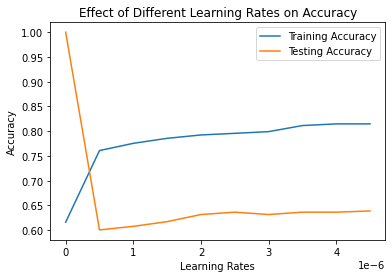

In [251]:
#Plot Training Accuracy
plt.plot(learning_rates, training_accuracy_list, label="Training Accuracy")

#Plot Testing Accuracy
plt.plot(learning_rates, testing_accuracy_list, label="Testing Accuracy")
    
plt.xlabel('Learning Rates')
plt.ylabel('Accuracy')

plt.legend()

plt.title('Effect of Different Learning Rates on Accuracy')
plt.show()

In [252]:
#Investigate Effect of Different Regularisation Parameters

#Pick 5 regularisation parameters
reg_params = [0.1 * i for i in range(5)]
print(reg_params)

#Lists to store training and testing accuracies for each learning rate
training_accuracy_list = []
testing_accuracy_list = [] 

#For each Regularisation Parameter
for i in range(0,len(reg_params)):
    print(f"Regularisation Parameter: {reg_params[i]}")
    training_accuracy, testing_accuracy = Logistic_Regression(reg_params[i], 0.000005,0.00005)
    training_accuracy_list.append(training_accuracy)
    testing_accuracy_list.append(testing_accuracy)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4]
Regularisation Parameter: 0.0
Error after Gradient Descent: 388.31452738586125
Time taken to train model: 119.98989200592041s
Training Accuracy: 81.58999999999999 %
Testing Accuracy: 63.63999999999999 %


Regularisation Parameter: 0.1
Error after Gradient Descent: 389.21174505476966
Time taken to train model: 111.77110028266907s
Training Accuracy: 81.58999999999999 %
Testing Accuracy: 63.63999999999999 %


Regularisation Parameter: 0.2
Error after Gradient Descent: 390.1089883414941
Time taken to train model: 109.22635316848755s
Training Accuracy: 81.58999999999999 %
Testing Accuracy: 63.63999999999999 %


Regularisation Parameter: 0.30000000000000004
Error after Gradient Descent: 391.00625724685807
Time taken to train model: 109.17794442176819s
Training Accuracy: 81.58999999999999 %
Testing Accuracy: 63.63999999999999 %


Regularisation Parameter: 0.4
Error after Gradient Descent: 391.90355177168504
Time taken to train model: 114.9563202857971

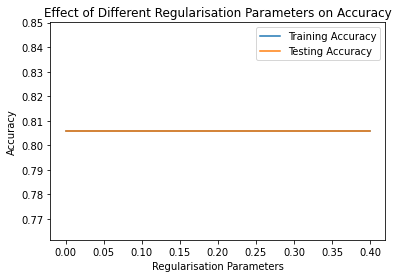

In [54]:
#Plot Training Accuracy
plt.plot(reg_params, training_accuracy_list, label="Training Accuracy")

#Plot Testing Accuracy
plt.plot(reg_params, testing_accuracy_list, label="Testing Accuracy")
    
plt.xlabel('Regularisation Parameters')
plt.ylabel('Accuracy')

plt.legend()

plt.title('Effect of Different Regularisation Parameters on Accuracy')
plt.show()

In [55]:
#Investigate Effect of Different Epsilon Parameters

#Pick 5 epsilon parameters
epsilon_params = [0.00001 * i for i in range(5)]
print(epsilon_params)

#Lists to store training and testing accuracies for each learning rate
training_accuracy_list = []
testing_accuracy_list = [] 

#For each Regularisation Parameter
for i in range(0,len(epsilon_params)):
    print(f"Epsilon Parameter: {epsilon_params[i]}")
    training_accuracy, testing_accuracy = Logistic_Regression(epsilon_params[i], 0.000005,0.00005)
    training_accuracy_list.append(training_accuracy)
    testing_accuracy_list.append(testing_accuracy)

[0.0, 1e-05, 2e-05, 3.0000000000000004e-05, 4e-05]
Epsilon Parameter: 0.0
Error after Gradient Descent: 392.81951649390453
Time taken to train model: 65.88241219520569s
Training Accuracy: 80.58 %
Epsilon Parameter: 1e-05
Error after Gradient Descent: 392.81961400626324
Time taken to train model: 64.39119791984558s
Training Accuracy: 80.58 %
Epsilon Parameter: 2e-05
Error after Gradient Descent: 392.8197115186223
Time taken to train model: 65.23132300376892s
Training Accuracy: 80.58 %
Epsilon Parameter: 3.0000000000000004e-05


KeyboardInterrupt: 

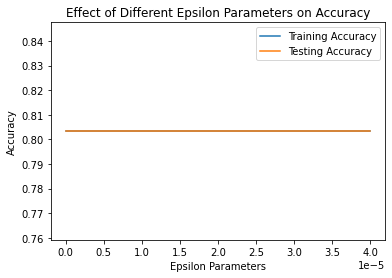

In [516]:
#Plot Training Accuracy
plt.plot(epsilon_params, training_accuracy_list, label="Training Accuracy")

#Plot Testing Accuracy
plt.plot(epsilon_params, testing_accuracy_list, label="Testing Accuracy")
    
plt.xlabel('Epsilon Parameters')
plt.ylabel('Accuracy')

plt.legend()

plt.title('Effect of Different Epsilon Parameters on Accuracy')
plt.show()

In [517]:
#Logistic_Regression(0.5,0.0000005,0.00005)